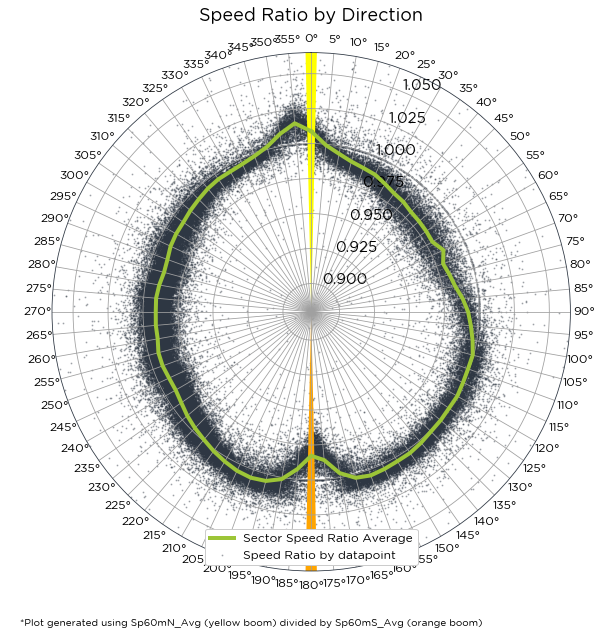

In [2]:
import pandas as pd
import numpy as np
import sys
path = r'C:\BW\RTD\repos-Shane\wind-analysis-scripts'
if path not in sys.path:
    sys.path.insert(1, path)

from analysis_tools import frequency_analysis as Ind
from analysis_tools.frequency_analysis import get_distribution_by_wind_sector as get_distribution_by_wind_sector
from analysis_tools.frequency_analysis import BWcolors as BWcolors
import matplotlib.pyplot as plt

path = r'C:\Dropbox (brightwind)\RTD\Coding Validation\Site2-Quixwood_60m_Clean.csv'
data = pd.read_csv(path)
time_col_name = 'TIMESTAMP'
yearfirst = False
dayfirst = True
data[time_col_name] = pd.to_datetime(data[time_col_name],dayfirst=dayfirst,yearfirst=yearfirst)
std_col_name = 'Sp60mS_Std'
speed_col_name = 'Sp60mS_Avg'
speed_col_name_boom_dir = 180
speed_col_name2 = 'Sp60mN_Avg'
speed_col_name2_boom_dir = 0
direction_col_name = 'Dir58mS_VAvg'
sectors = 72
min_speed = 0.1
time_interval = 10

  
    
Ind.plot_sector_ratio(data,speed_col_name,speed_col_name2,direction_col_name,boom_dir_1=speed_col_name_boom_dir,boom_dir_2=speed_col_name2_boom_dir, booms=True)

In [ ]:
import pandas as pd
import numpy as np
import sys
path = r'C:\BW\RTD\repos-Shane\wind-analysis-scripts'
if path not in sys.path:
    sys.path.insert(1, path)

#import turbulence_intensity as TI
import seaborn as sns
#from matplotlib import colors
import matplotlib.pyplot as plt
import mast_analysis as MA
import turbulence_intensity as TI

path = r'C:\Dropbox (brightwind)\RTD\BrightData\MERA\2018-05-25_MERA-LT-reference-quality\site-data\M352_Calib_Cleaned_20jan2011onwards.csv'
time_col_name = 'TIMESTAMP'
std_col_name = 'A_Std1'
speed_col_name = 'A_Avg1'
direction_col_name = 'WindDir_AVG'
sectors = 72
min_speed = 0.1
data = pd.read_csv(path)
time_interval = 10

def _map_speed_bin(wdspd, bins):
    # Copy of Inders function, can be removed once this is integrated into main library
    kwargs = {}
    if wdspd == max(bins):
        kwargs['right'] = True
    bin = bins[np.digitize([wdspd], bins, **kwargs)[0]]
    bin_lower = bins[np.digitize([wdspd], bins, **kwargs)[0]-1]
    return np.digitize([wdspd], bins, **kwargs)[0]-1.0

def _map_direction_bin(wdir, bins):
    # Copy of Inders function, can be removed once this is integrated into main library
    kwargs = {}
    if wdir == max(bins):
        kwargs['right'] = True
    bin = bins[np.digitize([wdir], bins, **kwargs)[0]]
    bin_lower = bins[np.digitize([wdir], bins, **kwargs)[0] - 1]
    return np.digitize([wdir], bins, **kwargs)[0]


def _get_direction_bin_dict(direction_bins,sectors):
    # Copy of Inders function, can be removed once this is integrated into main library
    map = dict()
    for i,lower_bound in enumerate(direction_bins[:sectors]):
        if i==0:
            map[i+1] = '{0}-{1}'.format(direction_bins[-2],direction_bins[1])
        else:
            map[i+1] = '{0}-{1}'.format(lower_bound,direction_bins[i+1])
    return map


def _get_direction_bin_array(sectors):
    # Copy of Inders function, can be removed once this is integrated into main library
    bin_start = 180.0/sectors
    direction_bins = np.arange(bin_start, 360, 360.0/sectors)
    direction_bins = np.insert(direction_bins,0,0)
    direction_bins = np.append(direction_bins,360)
    return direction_bins


data = data.dropna(subset=[speed_col_name, std_col_name, direction_col_name])
data['Turbulence_Intensity'] = data[std_col_name] / data[speed_col_name]

    #Reduce dataframe by excluding all values below Minimum Speed
data = data[data[speed_col_name] >= min_speed]
data[direction_col_name] = data[direction_col_name]-(360/(sectors*2))
data.loc[data[direction_col_name]<0,direction_col_name] += 360
    #Get Direction Bins, and then group data by bins while calculating mean TI and count the values
    #Note that sectors in Mast Analysis sheet calculated differently, first sector is not divided on either side of 0.
    #We have implemented sector division here.
direction_bins = np.arange(0,360+(360/sectors),360/sectors)
#data['Direction Bin'] = pd.cut(data[direction_col_name], direction_bins,right=False)
data = pd.concat([data, data.loc[:,direction_col_name].apply(_map_direction_bin,bins=direction_bins).rename('Direction Bin')],axis=1)

grouped = data.groupby(['Direction Bin'])
grouped1 = grouped['Turbulence_Intensity'].mean()
grouped2 = grouped['Turbulence_Intensity'].count()

result = pd.DataFrame({'Turbulence_Intensity_Avg': grouped1, 'Turbulence_Intensity_Count': grouped2})
result = result.reset_index()

    #Add first sector to last sector for Turbulence and for Count. Note is Averaging the best way to add TI in this case,
    # given different number of records in each???
#result.iloc[0, 1] = (result.iloc[0, 1] + result.iloc[sectors, 1]) / 2
#result.iloc[0, 2] = (result.iloc[0, 2] + result.iloc[sectors, 2])

    #Convert direction bins to actual bins, i.e. to include 345-15 degrees, and drop 345-360 sector
#result = result.drop([sectors])

#result = result.drop(columns=['Direction Bin'])
direction_row = _get_direction_bin_dict(_get_direction_bin_array(sectors), sectors)
new_bins = pd.Series(direction_row, name='bins', dtype='category')
new_bins = new_bins.reset_index()
result['Direction bin'] = new_bins['bins']
result = result[['Direction bin', 'Turbulence_Intensity_Avg', 'Turbulence_Intensity_Count']]
result
#direction_bins

#data = pd.concat([data, data.loc[:,direction_col_name].apply(_map_direction_bin,bins=_get_direction_bin_array(sectors)).rename('direction_bin')],axis=1)

In [ ]:
   def BWcolors(BWcolor):
    #Define color scheme to be used across graphs, and tables.
    if BWcolor == 'green':
        BWcolor = [156, 197, 55]
    elif BWcolor == 'asphault':
        BWcolor = [46, 55, 67]
    elif BWcolor == 'greyline':
        BWcolor = [108, 120, 134]
    elif BWcolor == 'darkgreen':
        BWcolor = [108, 144, 35]
    elif BWcolor == 'redline':
        BWcolor = [255, 0, 0]
    else:
        BWcolor = [156, 197, 55]

    BWcolor[:]=[x / 255 for x in BWcolor]
    return BWcolor
    
    
    columns = ['Windspeed', 'IEC Class A', 'IEC Class B', 'IEC Class C']
    IEC_Class_2005 = pd.DataFrame(np.zeros([26, 4]), columns=columns)

    for n in range(1, 26):
        IEC_Class_2005.iloc[n, 0] = n
        IEC_Class_2005.iloc[n, 1] = 0.16 * (0.75 + (5.6 / n))
        IEC_Class_2005.iloc[n, 2] = 0.14 * (0.75 + (5.6 / n))
        IEC_Class_2005.iloc[n, 3] = 0.12 * (0.75 + (5.6 / n))

    #Get Average Turbulence Intensity and Representative Turbulence Intensity for the plot
    #TI = get_TI_by_Speed(data, speed_col_name, std_col_name)
    data['Turbulence_Intensity'] = data[std_col_name] / data[speed_col_name]

    #Plot Figure
    plt.figure(figsize=(15, 7.5))
    plt.scatter([data[speed_col_name]], [data['Turbulence_Intensity']], color=BWcolors('green'), s=1, alpha=0.3)
    plt.plot(TI.iloc[:, 0], TI.iloc[:, 1], color=BWcolors('darkgreen'))
    plt.plot(TI.iloc[:, 0], TI.iloc[:, 5], color=BWcolors('redline'))
    plt.plot(IEC_Class_2005.iloc[:, 0], IEC_Class_2005.iloc[:, 1], color=BWcolors('greyline'))
    plt.plot(IEC_Class_2005.iloc[:, 0], IEC_Class_2005.iloc[:, 2], color=BWcolors('greyline'))
    plt.plot(IEC_Class_2005.iloc[:, 0], IEC_Class_2005.iloc[:, 3], color=BWcolors('greyline'))
    plt.axis([2, 25, 0, 0.6])
    plt.xticks(np.arange(2, 26, 1))
    plt.xlabel('Wind speed [m/s]')
    plt.ylabel('Turbulence Intensity')
    # plt.title('Turbulence Intensity by Windspeed for ' + str(speed_col))
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
TI.get_TI_by_Speed(data,speed_col_name,std_col_name)

In [ ]:
TI.plot_TI_by_Speed(data,speed_col_name,std_col_name)

In [ ]:
TI.get_TI_by_sector(data,speed_col_name,std_col_name,direction_col_name,sectors,min_speed)

In [ ]:
TI.plot_TI_by_sector(data,speed_col_name,std_col_name,direction_col_name,sectors,min_speed)

In [ ]:
TI.get_12x24_TI_matrix(data,time_col,speed_col_name,std_col_name)

In [ ]:
import sys
path = r'C:\BW\RTD\repos-Shane\wind-analysis-scripts'
if path not in sys.path:
    sys.path.insert(1, path)

#import turbulence_intensity as TI
import seaborn as sns
#from matplotlib import colors
#import matplotlib.pyplot as plt
import mast_analysis as MA

path = r'C:\Dropbox (brightwind)\RTD\BrightData\MERA\2018-05-25_MERA-LT-reference-quality\site-data\M352_Calib_Cleaned_20jan2011onwards.csv'
time_col_name = 'TIMESTAMP'
std_col_name = 'A_Std1'
speed_col_name = 'A_Avg1'
direction_col_name = 'WindDir_AVG'
sectors = 72
min_speed = 0.1
data = pd.read_csv(path)
time_interval = 10

cov_table = MA.get_monthly_coverage(data,time_col_name,time_interval)

cm = sns.light_palette("seagreen", as_cmap=True)

s = (cov_table.style
         .background_gradient(cmap=cm,low=0,high=1)
         .format("{:.1%}")
    )
s

In [1]:
import pandas as pd
import numpy as np
import sys
path = r'C:\BW\RTD\repos-Shane\wind-analysis-scripts'
if path not in sys.path:
    sys.path.insert(1, path)

from analysis_tools import frequency_analysis as Ind
from analysis_tools.frequency_analysis import BWcolors as BWcolors

path = r'C:\Dropbox (brightwind)\RTD\Coding Validation\Site2-Quixwood_60m_Clean.csv'
data = pd.read_csv(path)
time_col_name = 'TIMESTAMP'
yearfirst = False
dayfirst = True
data[time_col_name] = pd.to_datetime(data[time_col_name],dayfirst=dayfirst,yearfirst=yearfirst)
std_col_name = 'Sp60mS_Std'
speed_col_name = 'Sp60mS_Avg'
speed_col_name2 = 'Sp60mN_Avg'
direction_col_name = 'Dir58mS_VAvg'
sectors = 72
min_speed = 0.1
time_interval = 10


#data = data.loc[data[speed_col_name2] >= 3] 
#data = data.loc[data[speed_col_name] >= 3 ]
data = data[data[speed_col_name] >= 3]
data = data[data[speed_col_name2] >= 3]
#data[speed_col_name] = data.iloc[data[speed_col_name] >= 3 ]
#data = data[direction_col_name].dropna()
data['Speedsector'] = data[speed_col_name2] / data[speed_col_name]
data[direction_col_name] = data[direction_col_name].mod(360)

#pd.set_option('display.max_rows', 1500) 
#data.iloc[2250:3000,:]
direction_bins = np.arange(0,361,360/sectors)


SectorRatio = Ind.get_distribution_by_wind_sector(data['Speedsector'], data[direction_col_name], sectors=sectors, aggregation_method='count',
                                    direction_bin_array=direction_bins, direction_bin_labels=None)

#SectorRatio.reset_index()

pd.set_option('display.max_rows', 500) 
SectorRatio


0.0-5.0         890
5.0-10.0        949
10.0-15.0       951
15.0-20.0       986
20.0-25.0       947
25.0-30.0       886
30.0-35.0      1015
35.0-40.0       817
40.0-45.0       782
45.0-50.0       770
50.0-55.0       835
55.0-60.0       714
60.0-65.0       594
65.0-70.0       499
70.0-75.0       481
75.0-80.0       353
80.0-85.0       353
85.0-90.0       474
90.0-95.0       524
95.0-100.0      458
100.0-105.0     755
105.0-110.0     974
110.0-115.0     875
115.0-120.0     841
120.0-125.0     958
125.0-130.0    1056
130.0-135.0    1235
135.0-140.0    1498
140.0-145.0    1347
145.0-150.0    1354
150.0-155.0    1544
155.0-160.0    1326
160.0-165.0    1057
165.0-170.0     961
170.0-175.0     947
175.0-180.0    1084
180.0-185.0    1090
185.0-190.0    1255
190.0-195.0    1476
195.0-200.0    1777
200.0-205.0    2353
205.0-210.0    3043
210.0-215.0    3468
215.0-220.0    3943
220.0-225.0    4741
225.0-230.0    4764
230.0-235.0    4160
235.0-240.0    3726
240.0-245.0    3485
245.0-250.0    3760


In [1]:
import pandas as pd
import numpy as np
import sys
path = r'C:\BW\RTD\repos-Shane\wind-analysis-scripts'
if path not in sys.path:
    sys.path.insert(1, path)

from analysis_tools import frequency_analysis as Ind
from analysis_tools.frequency_analysis import BWcolors as BWcolors

path = r'C:\Dropbox (brightwind)\RTD\Coding Validation\Site2-Quixwood_60m_Clean_Access_Export.csv'
data = pd.read_csv(path)
time_col_name = 'TIMESTAMP'
yearfirst = False
dayfirst = True
data[time_col_name] = pd.to_datetime(data[time_col_name],dayfirst=dayfirst,yearfirst=yearfirst)
std_col_name = 'Sp60mS_Std'
speed_col_name = 'Sp60mS_Avg'
speed_col_name2 = 'Sp60mN_Avg'
direction_col_name = 'Dir58mS_VAvg'
sectors = 72
min_speed = 0.1
time_interval = 10

def _map_direction_bin(wdir, bins):
    # Copy of Inders function, can be removed once this is integrated into main library
    kwargs = {}
    if wdir == max(bins):
        kwargs['right'] = True
    bin = bins[np.digitize([wdir], bins, **kwargs)[0]]
    bin_lower = bins[np.digitize([wdir], bins, **kwargs)[0] - 1]
    return np.digitize([wdir], bins, **kwargs)[0]

data = data.dropna(subset=[speed_col_name,speed_col_name2,direction_col_name])
data = data[data[speed_col_name] >= 3]
data = data[data[speed_col_name2] >= 3]
data['Speedsector'] = data[speed_col_name2] / data[speed_col_name]
data[direction_col_name] = data[direction_col_name].mod(360)

direction_bins = np.arange(0,360+(360/sectors),360/sectors)
#data = pd.concat([data, data.loc[:, direction_col_name].apply(_map_direction_bin,bins=direction_bins).rename('Direction Bin')], axis=1)
data['Direction Bin'] = pd.cut(data[direction_col_name], direction_bins,right=False)

grouped = data.groupby(['Direction Bin'])
#grouped1 = grouped['Speedsector'].mean()
#grouped2 = grouped['Speedsector'].count()
grouped3 = grouped[speed_col_name2].mean()
grouped4 = grouped[speed_col_name].mean()
grouped5 = grouped[speed_col_name2].count()

#result = pd.DataFrame({'Sector Ratio': grouped1, 'Sector count':grouped2})
result = pd.DataFrame({'Sp1': grouped3, 'Sp2':grouped4, 'count':grouped5, 'Ratio':grouped3/grouped4})
result = result.reset_index()
result


,Direction Bin,Sp1,Sp2,count,Ratio
0,"[0.0, 5.0)",6.863101,6.842191,890,1.003056
1,"[5.0, 10.0)",6.912476,6.944837,949,0.995340
2,"[10.0, 15.0)",6.315910,6.374416,951,0.990822
3,"[15.0, 20.0)",6.429462,6.505568,986,0.988301
4,"[20.0, 25.0)",6.327983,6.406463,947,0.987750
5,"[25.0, 30.0)",5.868544,5.951941,886,0.985988
6,"[30.0, 35.0)",6.050808,6.153576,1015,0.983299
7,"[35.0, 40.0)",6.127968,6.242240,817,0.981694
8,"[40.0, 45.0)",6.150064,6.273082,782,0.980390
9,"[45.0, 50.0)",6.234325,6.363675,770,0.979674
